# Time Series Forecasting with BigFrames

This notebook provides a comprehensive walkthrough of time series forecasting using the BigFrames library. We will explore two powerful models, TimesFM and ARIMAPlus, to predict bikeshare trip demand based on historical data from San Francisco. The process covers data loading, preprocessing, model training, and visualization of the results.

In [1]:
import bigframes.pandas as bpd
bpd.options.display.repr_mode = "anywidget"

### 1. Data Loading and Preprocessing

The first step is to load the San Francisco bikeshare dataset from BigQuery. We then preprocess the data by filtering for trips made by 'Subscriber' type users from 2018 onwards. This ensures we are working with a relevant and consistent subset of the data. Finally, we aggregate the trip data by the hour to create a time series of trip counts.

In [2]:
# Load the bikeshare dataset from the public BigQuery repository.
df = bpd.read_gbq("bigquery-public-data.san_francisco_bikeshare.bikeshare_trips")

# Filter the data to focus on a specific time period and user type.
df = df[df["start_date"] >= "2018-01-01"]
df = df[df["subscriber_type"] == "Subscriber"]

# Resample the data to an hourly frequency by counting the number of trips in each hour.
df["trip_hour"] = df["start_date"] .dt.floor("h")
df_grouped = df[["trip_hour", "trip_id"]].groupby("trip_hour").count().reset_index()
df_grouped = df_grouped.rename(columns={"trip_id": "num_trips"})

### 2. Forecasting with TimesFM

In this section, we use the TimesFM (Time Series Foundation Model) to forecast future bikeshare demand. TimesFM is a powerful model designed for a wide range of time series forecasting tasks. We will use it to predict the number of trips for the last week of our dataset.

In [3]:
# Use the TimesFM model to forecast the last 168 hours (one week).
# The `timestamp_column` specifies the time index of the series.
# The `data_column` is the value we want to forecast.
# The `horizon` defines how many steps into the future to predict.
result = df_grouped.head(2842-168).ai.forecast(
    timestamp_column="trip_hour",
    data_column="num_trips",
    horizon=168
)
result

/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/dataframe.py:5329: FutureWarning: The 'ai' property will be removed. Please use 'bigframes.bigquery.ai'
instead.
  warnings.warn(msg, category=FutureWarning)


forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
2018-04-24 14:00:00+00:00,126.519211,0.950000,96.837778,156.200644,
2018-04-30 21:00:00+00:00,82.266197,0.950000,-7.690994,172.223388,
2018-04-25 14:00:00+00:00,130.057266,0.950000,78.019585,182.094948,
2018-04-26 06:00:00+00:00,47.235214,0.950000,-16.565634,111.036063,
2018-04-28 01:00:00+00:00,0.761139,0.950000,-61.080531,62.602809,
2018-04-27 11:00:00+00:00,160.437042,0.950000,80.767928,240.106157,
2018-04-25 07:00:00+00:00,321.418488,0.950000,207.344246,435.492729,
2018-04-24 16:00:00+00:00,284.640564,0.950000,198.550187,370.730941,
2018-04-25 16:00:00+00:00,329.653748,0.950000,201.918472,457.389023,
2018-04-26 10:00:00+00:00,160.995972,0.950000,67.706721,254.285223,


### 3. Forecasting with ARIMAPlus

Next, we will use the ARIMAPlus model, which is a BigQuery ML model available through BigFrames. ARIMAPlus is an advanced forecasting model that can capture complex time series patterns. We will train it on the same historical data and use it to forecast the same period as the TimesFM model.

In [4]:
from bigframes.ml import forecasting

# Create and configure an ARIMAPlus model for hourly data.
# `auto_arima_max_order` is set to a lower value to reduce the training time.
# `data_frequency` is set to 'hourly' to match our aggregated data.
model = forecasting.ARIMAPlus(
    auto_arima_max_order=5,  # Reduce runtime for large datasets
    data_frequency="hourly",
    horizon=168
)

# Prepare the training data by excluding the last week.
X = df_grouped.head(2842-168)[["trip_hour"] ]
y = df_grouped.head(2842-168)[["num_trips"] ]

# Fit the model to the training data.
model.fit(
    X, y
)

# Generate predictions for the specified horizon.
predictions = model.predict(horizon=168, confidence_level=0.95)
predictions

forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
2018-04-24 00:00:00+00:00,52.768335,34.874520,0.950000,-15.462203,120.998872,-15.462203,120.998872
2018-04-24 01:00:00+00:00,67.328100,48.075255,0.950000,-26.729122,161.385322,-26.729122,161.385322
2018-04-24 02:00:00+00:00,75.205573,53.910921,0.950000,-30.268884,180.680030,-30.268884,180.680030
2018-04-24 03:00:00+00:00,80.070922,55.994076,0.950000,-29.479141,189.620985,-29.479141,189.620985
2018-04-24 04:00:00+00:00,75.161779,56.583974,0.950000,-35.542394,185.865952,-35.542394,185.865952
2018-04-24 05:00:00+00:00,81.428432,56.850870,0.950000,-29.797913,192.654778,-29.797913,192.654778
2018-04-24 06:00:00+00:00,116.981445,57.180767,0.950000,5.109671,228.853218,5.109671,228.853218
2018-04-24 07:00:00+00:00,237.222361,57.770307,0.950000,124.197176,350.247546,124.197176,350.247546
2018-04-24 08:00:00+00:00,323.722572,58.681662,0.950000,208.914360,438.530784,208.914360,438.530784
2018-04-24 09:00:00+00:00,357.288952,59.806906,0.950000,240.279247,474.298656,240.279247,474.298656


### 4. Compare and Visualize Forecasts

Now we will visualize the forecasts from both TimesFM and ARIMAPlus against the actual historical data. This allows for a direct comparison of the two models' performance.

<Axes: xlabel='trip_hour'>

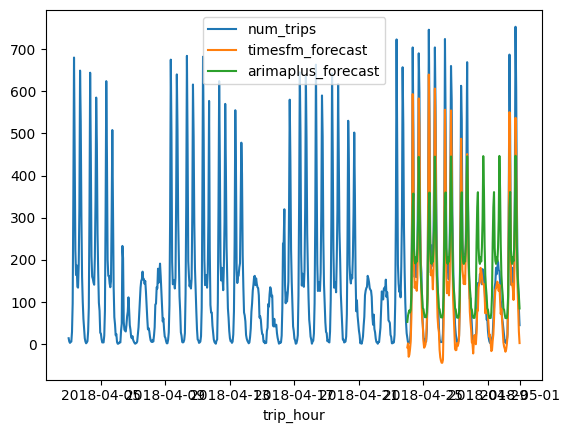

In [5]:
# Prepare the TimesFM forecast data.
timesfm_result = result.sort_values("forecast_timestamp")[ [ "forecast_timestamp", "forecast_value" ] ]
timesfm_result = timesfm_result.rename(columns={
    "forecast_timestamp": "trip_hour",
    "forecast_value": "timesfm_forecast"
})

# Prepare the ARIMAPlus forecast data.
arimaplus_result = predictions.sort_values("forecast_timestamp")[ [ "forecast_timestamp", "forecast_value" ] ]
arimaplus_result = arimaplus_result.rename(columns={
    "forecast_timestamp": "trip_hour",
    "forecast_value": "arimaplus_forecast"
})

# Merge the forecasts with the original data.
df_all = df_grouped.merge(timesfm_result, on="trip_hour", how="left")
df_all = df_all.merge(arimaplus_result, on="trip_hour", how="left")

# Plot the last 4 weeks of data for comparison.
df_all.tail(672).plot.line(x="trip_hour", y=["num_trips", "timesfm_forecast", "arimaplus_forecast"])

### 5. Multiple Time Series Forecasting

This section demonstrates a more advanced capability of ARIMAPlus: forecasting multiple time series simultaneously. This is useful when you have several independent series that you want to model together, such as trip counts from different bikeshare stations. The `id_col` parameter is key here, as it is used to differentiate between the individual time series.

In [6]:
# Filter for specific stations to create a dataset with multiple distinct time series.
df_multi = bpd.read_gbq("bigquery-public-data.san_francisco_bikeshare.bikeshare_trips")
df_multi = df_multi[df_multi["start_station_name"] .str.contains("Market|Powell|Embarcadero")]

# Group the data by station and date to create a time series for each station.
features = bpd.DataFrame({
    "start_station_name": df_multi["start_station_name"],
    "num_trips": df_multi["start_date"],
    "date": df_multi["start_date"] .dt.date,
})
num_trips = features.groupby(
    [ "start_station_name", "date" ], as_index=False
 ).count()

# Fit the model, using the 'start_station_name' column to identify each individual time series.
model.fit (
    num_trips[["date"]],
    num_trips[["num_trips"]],
    id_col=num_trips[["start_station_name"] ]
)

# Predict the future values for each time series.
predictions_multi = model.predict()
predictions_multi

/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/core/log_adapter.py:182: TimeTravelCacheWarning: Reading cached table from 2025-12-05 04:49:35.785712+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)
/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/ml/forecasting.py:239: UserWarning: Converting Date column 'date' to datetime for hourly frequency. This is required because BigQuery ML doesn't support Date type with hourly frequency.
  warnings.warn(


forecast_timestamp,start_station_name,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
2016-08-31 01:00:00+00:00,Beale at Market,28.768069,0.145449,0.950000,28.483504,29.052633,28.483504,29.052633
2016-08-31 01:00:00+00:00,Civic Center BART (7th at Market),16.877399,0.116440,0.950000,16.649589,17.105210,16.649589,17.105210
2016-08-31 01:00:00+00:00,Embarcadero at Bryant,23.960762,0.115089,0.950000,23.735596,24.185928,23.735596,24.185928
2016-08-31 01:00:00+00:00,Embarcadero at Folsom,23.640867,0.142805,0.950000,23.361474,23.920259,23.361474,23.920259
2016-08-31 01:00:00+00:00,Embarcadero at Sansome,48.193322,0.242131,0.950000,47.719603,48.667041,47.719603,48.667041
2016-08-31 01:00:00+00:00,Embarcadero at Vallejo,16.076407,0.141602,0.950000,15.799369,16.353444,15.799369,16.353444
2016-08-31 01:00:00+00:00,Market at 10th,30.614706,0.193238,0.950000,30.236644,30.992768,30.236644,30.992768
2016-08-31 01:00:00+00:00,Market at 4th,22.765137,0.164358,0.950000,22.443578,23.086695,22.443578,23.086695
2016-08-31 01:00:00+00:00,Market at Sansome,44.291054,0.219354,0.950000,43.861898,44.720210,43.861898,44.720210
2016-08-31 01:00:00+00:00,Mechanics Plaza (Market at Battery),12.995115,0.005255,0.950000,12.984834,13.005396,12.984834,13.005396
